# Part 1 ‐ Exploratory data analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import kpss
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score,  roc_curve
import warnings

### Read in JSON file

In [2]:
logins = pd.read_json('logins.json')

### View the data

In [3]:
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

### Break date column into constituant parts

In [4]:
logins['login_time_string'] = logins['login_time'].astype(str)
logins[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = logins['login_time_string'].str.split(' |-|:', expand=True)
logins[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = logins[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']].astype(int)
logins = logins[['login_time', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']]

### Assign the login times 15 minute buckets

In [5]:
bins = list(range(-1, 61, 15))
labels = list(range(0, 60, 15))
logins['Minute Bucket'] = pd.cut(logins['Minute'], bins=bins, labels=labels).astype(int)
logins = logins.rename({'Minute': 'Minute original', 'Minute Bucket': 'Minute'}, axis=1)
logins['Date Bucket'] = pd.to_datetime(logins[['Year', 'Month', 'Day', 'Hour', 'Minute']])

### Get day of week and identify the times on Weekends

In [6]:
logins['Day of Week'] = logins['Date Bucket'].dt.dayofweek
day_name_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
logins['Day Name'] = logins['Day of Week'].map(day_name_mapping)
logins['Weekend'] = logins['Day Name'].apply(lambda x: 'Yes' if x in ['Saturday', 'Sunday'] else 'No' )

### Aggregate the logins into 15 minute buckets

In [7]:
logins_per_bucket = logins.groupby(['Date Bucket']).agg({
    'Date Bucket': 'count',
    'Weekend': 'first'
}).rename({'Date Bucket': '# of Logins'}, axis=1)

### Make the 15 minute date buckets the index, resample it for every 15 minutes, and fill in any values for missing times with the previous time's value

In [8]:
logins_per_bucket = logins_per_bucket.reset_index().set_index('Date Bucket')
logins_per_bucket = logins_per_bucket.resample('15min').asfreq()
logins_per_bucket = logins_per_bucket.ffill()

### Mark the start and end of each weekend

In [9]:
weekends = logins_per_bucket.loc[logins_per_bucket['Weekend']=='Yes']
weekends = weekends.reset_index()
weekends['Start'] = weekends['Date Bucket'].dt.date.apply(lambda x: pd.to_datetime(str(x)))
weekends['End'] = weekends['Start'] + pd.DateOffset(days=1)
weekends = weekends[['Start', 'End']].drop_duplicates().reset_index(drop=True)

### Plot the logins over time (weekends are highlighted in red)

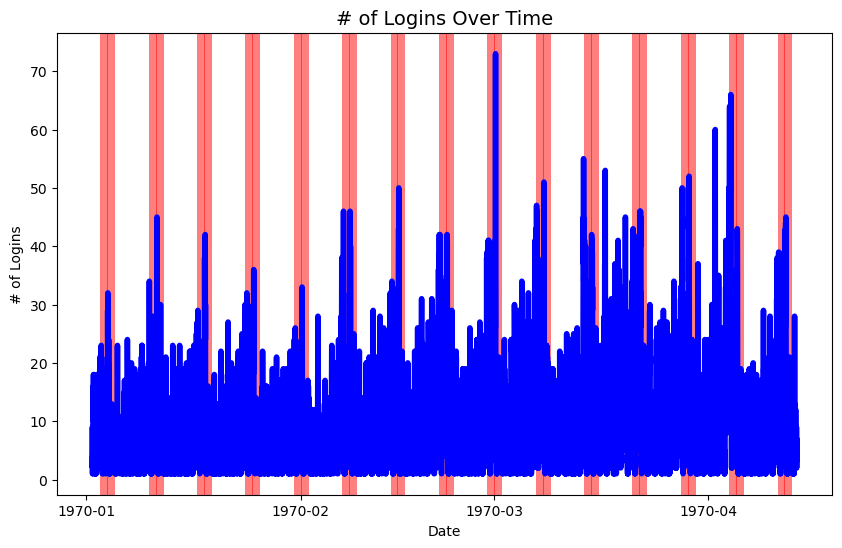

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('fivethirtyeight')
_ = ax.plot(logins_per_bucket.index, logins_per_bucket["# of Logins"], linestyle='-', color='blue')
_ = ax.set_title('# of Logins Over Time', fontsize=14)
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('# of Logins')
_ = ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
for i in range(len(weekends)):
    ax.axvspan(weekends['Start'].iloc[i], weekends['End'].iloc[i], color='red', alpha=.5)

After plotting the number of logins over time, it appears that the number of logins peak on weekends. There also appears to be a weekly pattern overall. Next, I will look at each month individually, to see what that looks like.

### Plot the logins over time by month (weekends are highlighted in red)

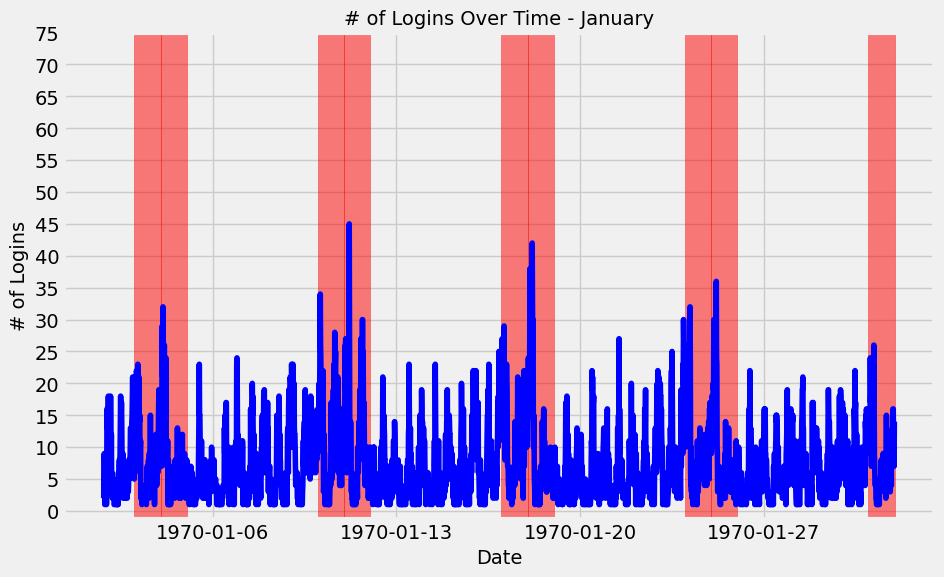

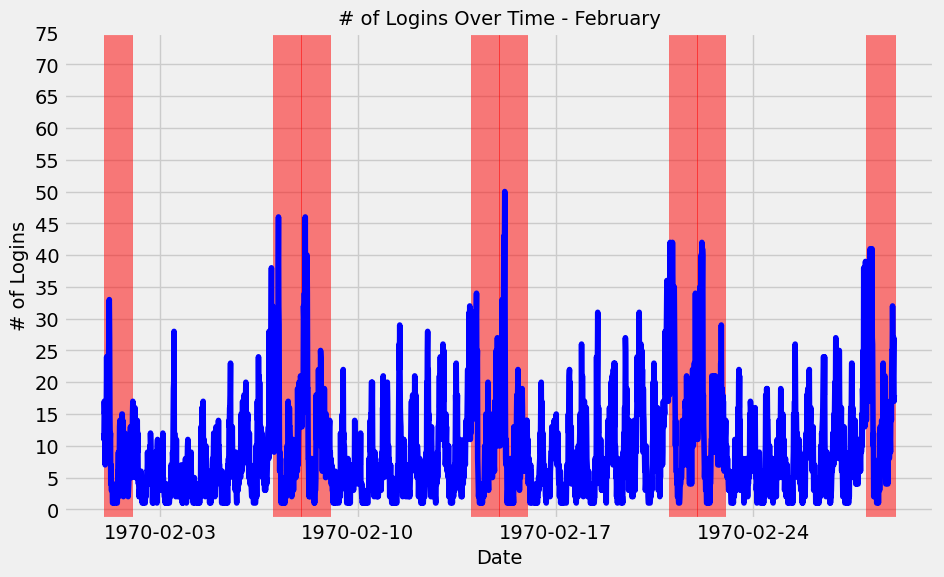

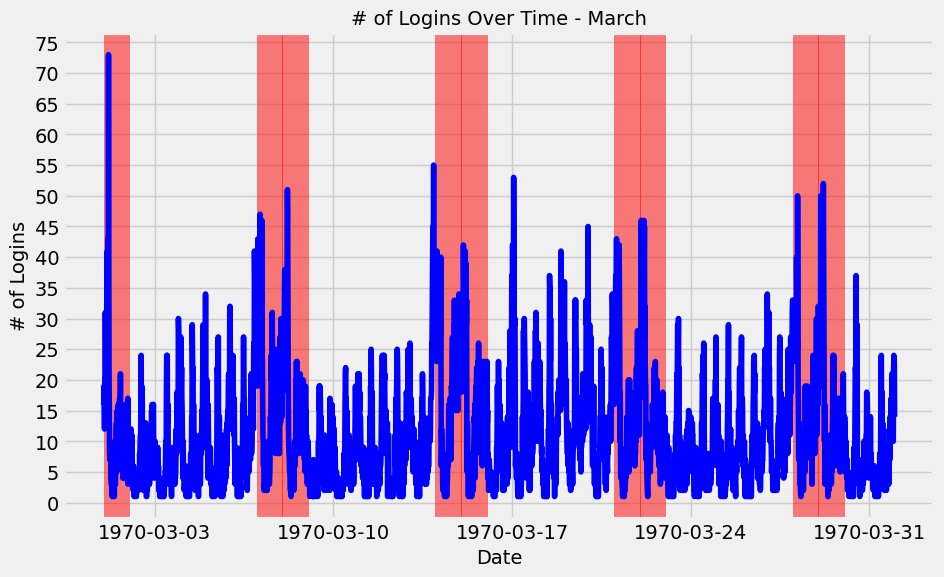

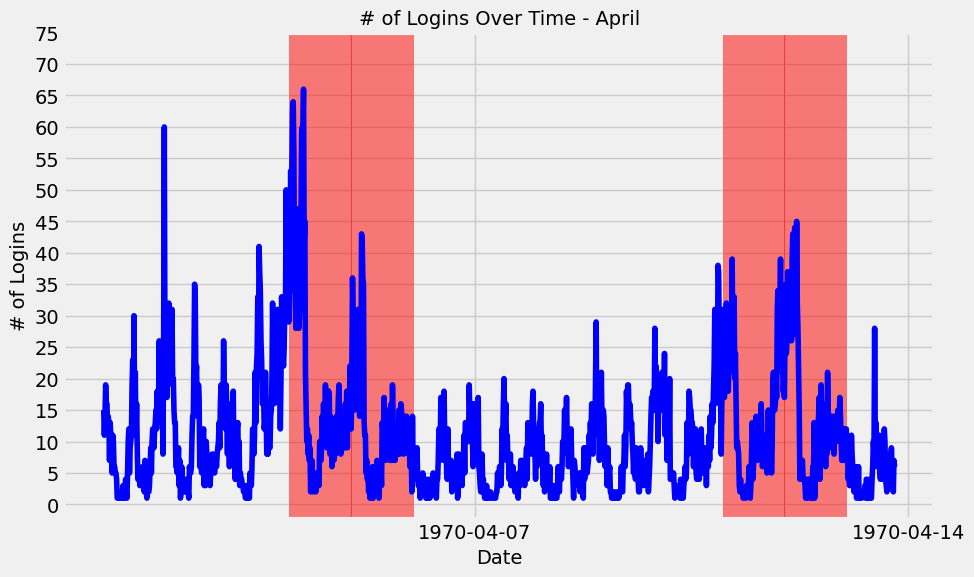

In [11]:
for month in ['01', '02', '03', '04']:
    fig, ax = plt.subplots(figsize=(10, 6))
    weekends_month = weekends.set_index('Start')
    weekends_month = weekends_month['1970-' + month: '1970-' + month]
    weekends_month = weekends_month.reset_index()
    data = logins_per_bucket['1970-'+ month:'1970-' + month]
    month_name_mapping = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April'
    }
    month_name = data.index.month.map(month_name_mapping)[0]
    _ = ax.plot(data.index, data["# of Logins"], linestyle='-', color='blue')
    _ = ax.set_title('# of Logins Over Time - ' + month_name, fontsize=14)
    _ = ax.set_xlabel('Date')
    _ = ax.set_ylabel('# of Logins')
    _ = ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    _ = ax.set_yticks(list(range(0, 76, 5)))
    for i in range(len(weekends_month)):
        ax.axvspan(weekends_month['Start'].iloc[i], weekends_month['End'].iloc[i], color='red', alpha=0.5)

Looking at these graphs, the weekends indeed appear to be the peak time for logins. Additionally, the number of logins appears to be increasing a bit over time and from Monday to Friday. Let's examine this.

### Plot average number logins per bucket by month

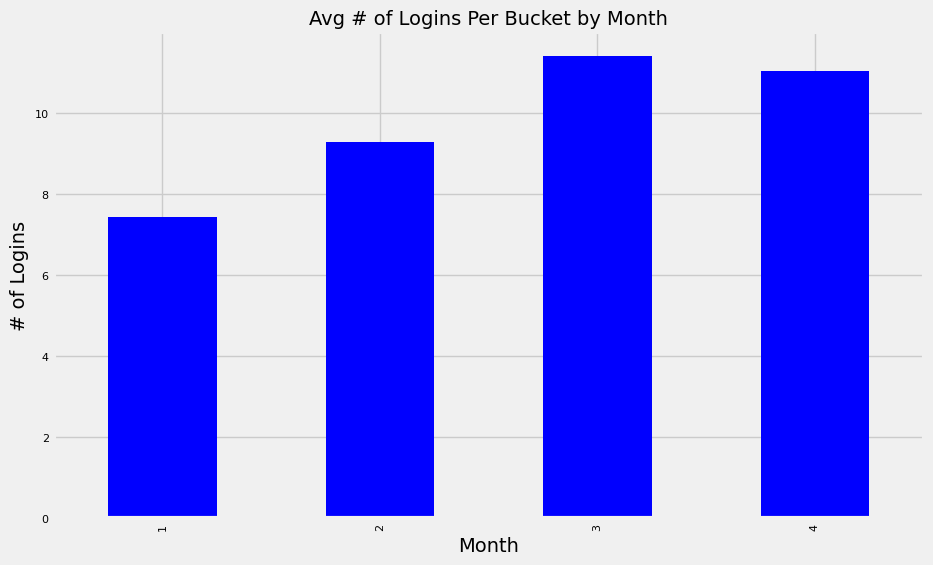

In [12]:
index_month = logins_per_bucket.index.month
monthly_logins = logins_per_bucket.groupby(index_month)['# of Logins'].mean()
ax = monthly_logins.plot(figsize=(10, 6), kind='bar', color='blue', fontsize=8)
_ = ax.set_title('Avg # of Logins Per Bucket by Month', fontsize=14)
_ = ax.set_xlabel('Month')
_ = ax.set_ylabel('# of Logins')

### Plot daily logins over time

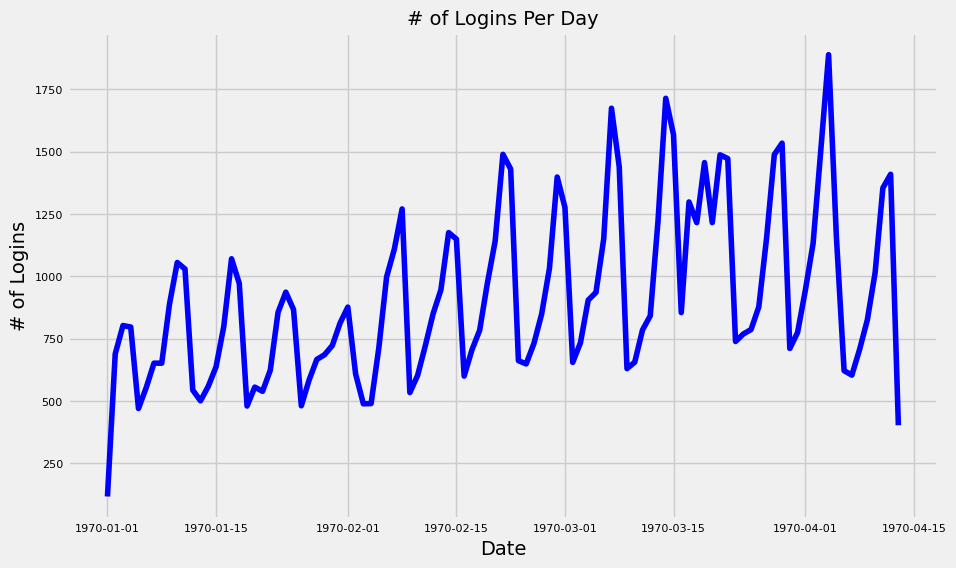

In [13]:
index_day = logins_per_bucket.index.date
daily_logins = logins_per_bucket.groupby(index_day)['# of Logins'].sum()
ax = daily_logins.plot(figsize=(10, 6), linestyle='-', color='blue', fontsize=8)
_ = ax.set_title('# of Logins Per Day', fontsize=14)
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('# of Logins')

There does indeed appear to be a trend of logins increasing over time, and while April doesn't increase over March, we only have half a month to go by.

### Plot average logins per bucket by day of week

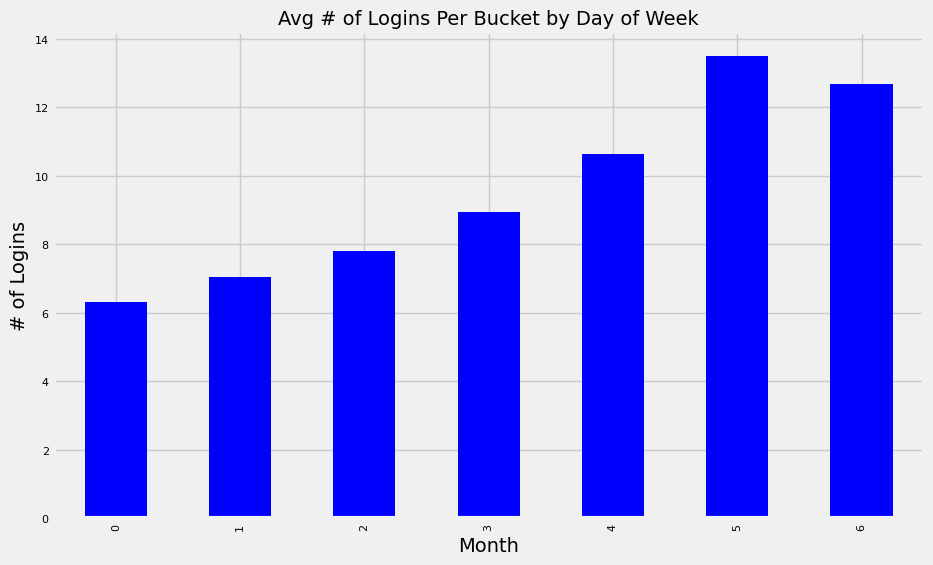

In [14]:
index_weekday = logins_per_bucket.index.dayofweek
day_logins = logins_per_bucket.groupby(index_weekday)['# of Logins'].mean()
ax = day_logins.plot(figsize=(10, 6), kind='bar', color='blue', fontsize=8)
_ = ax.set_title('Avg # of Logins Per Bucket by Day of Week', fontsize=14)
_ = ax.set_xlabel('Month')
_ = ax.set_ylabel('# of Logins')

There also is a trend where logins peak on weekends, hit a low on Monday, and then gradually increase over the course of the week.

### Plot # of logins by hour of day (all days of week combined)

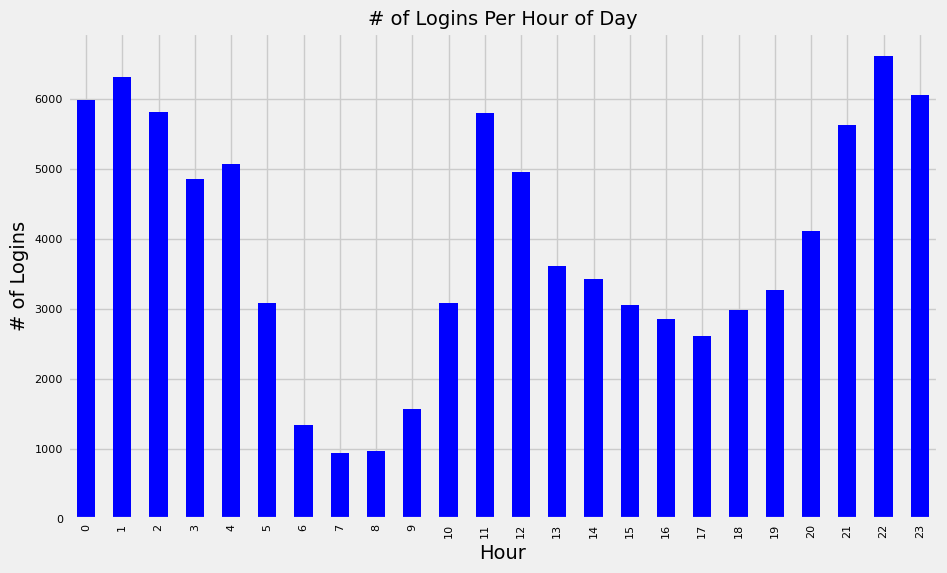

In [15]:
index_hour = logins_per_bucket.index.hour
hourly_logins = logins_per_bucket.groupby(index_hour)['# of Logins'].sum()
ax = hourly_logins.plot(figsize=(10, 6), kind='bar', color='blue', fontsize=8)
_ = ax.set_title('# of Logins Per Hour of Day', fontsize=14)
_ = ax.set_xlabel('Hour')
_ = ax.set_ylabel('# of Logins')

Looking at this graph, we see that the majority of logins occur in the early morning, at night, and at 11 and 12 AM. Also, more logins occur in the afternoon than in the middle of the morning. This suggests that people are logging in when they are off work (at least first shift) or at lunch. Let's look at it by day of week to see if this makes sense.

### Plot # of logins by hour of day and day of week

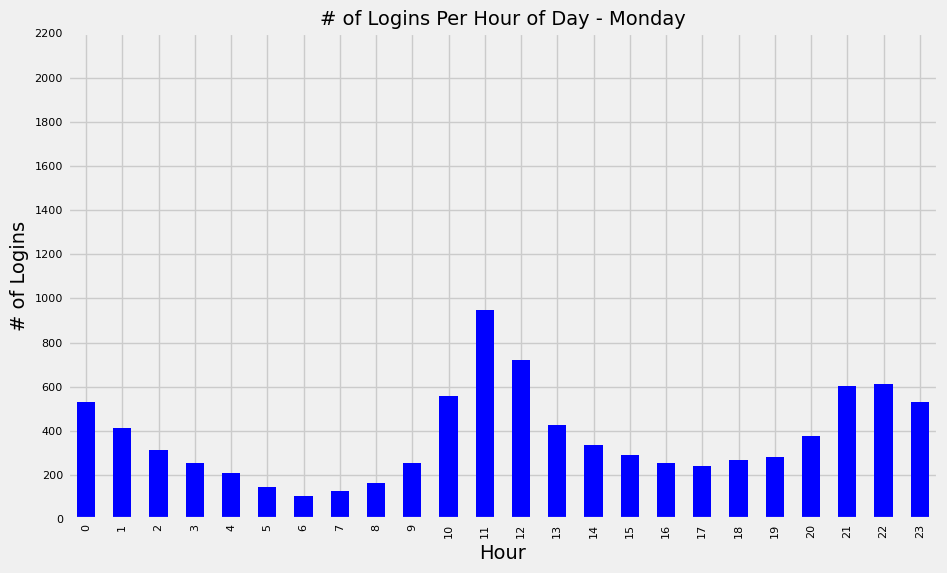

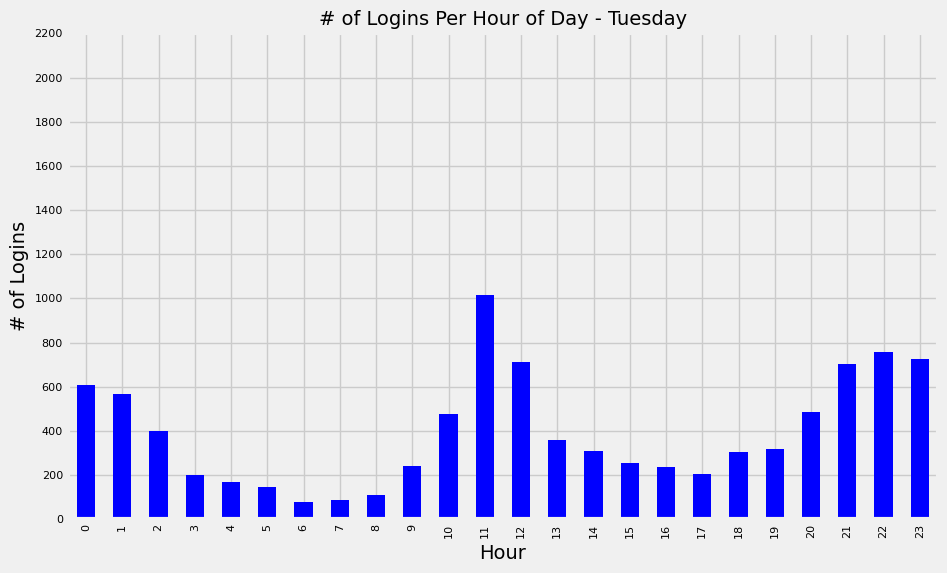

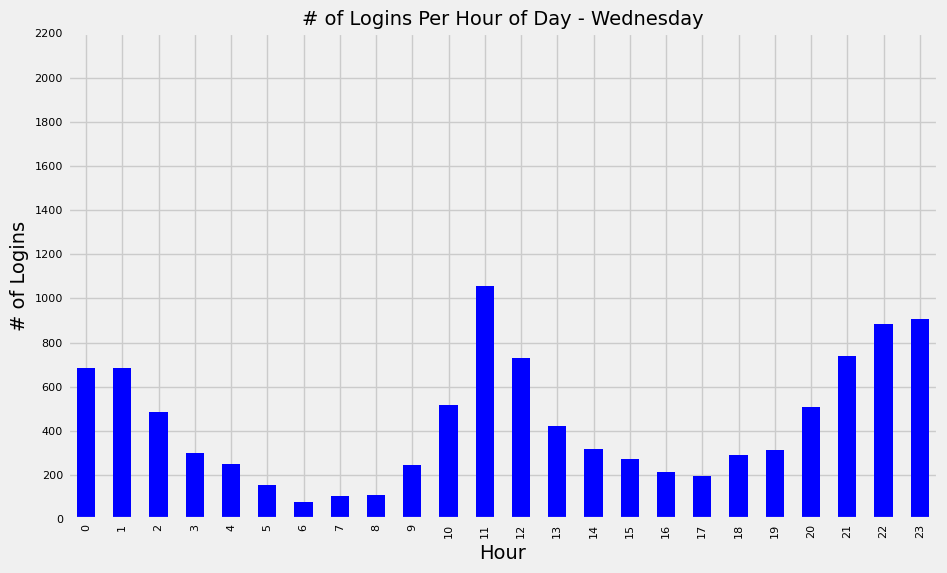

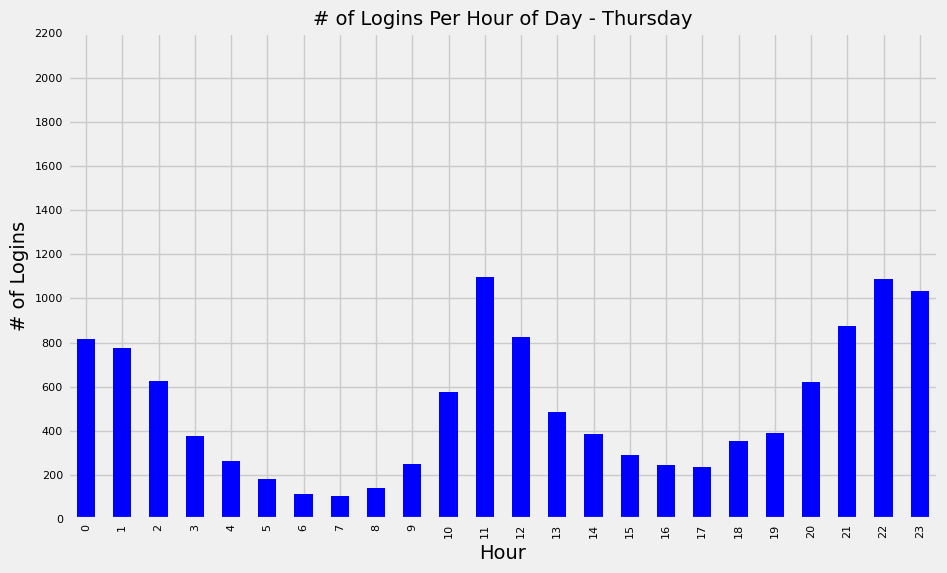

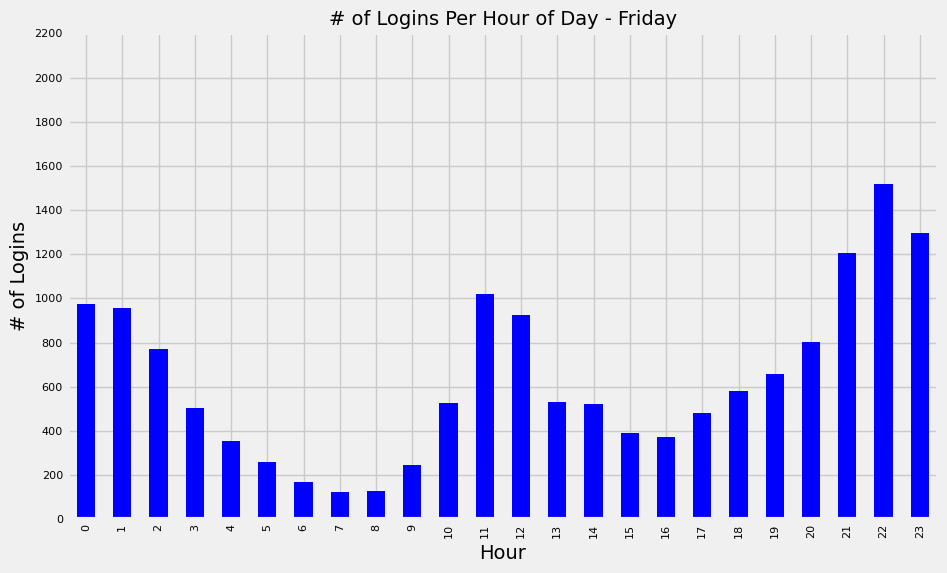

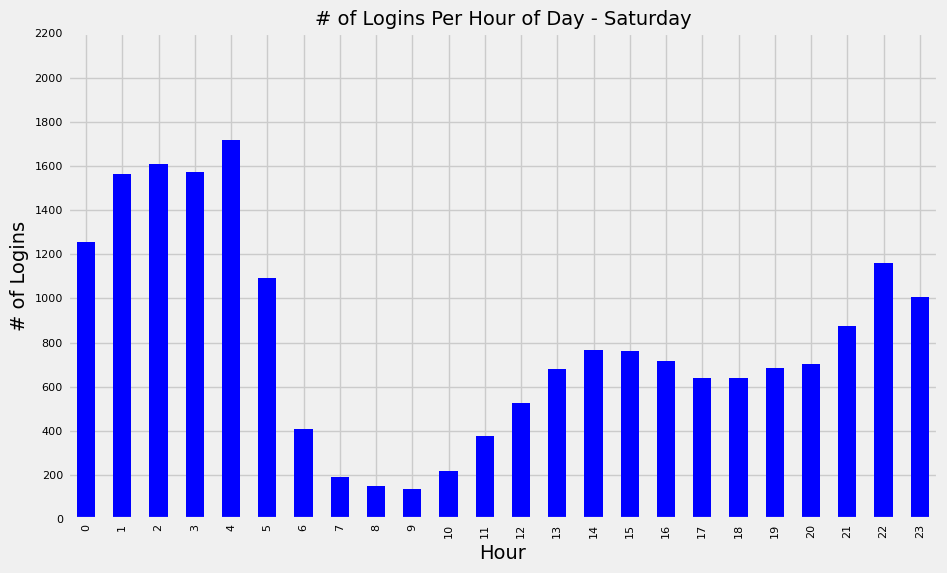

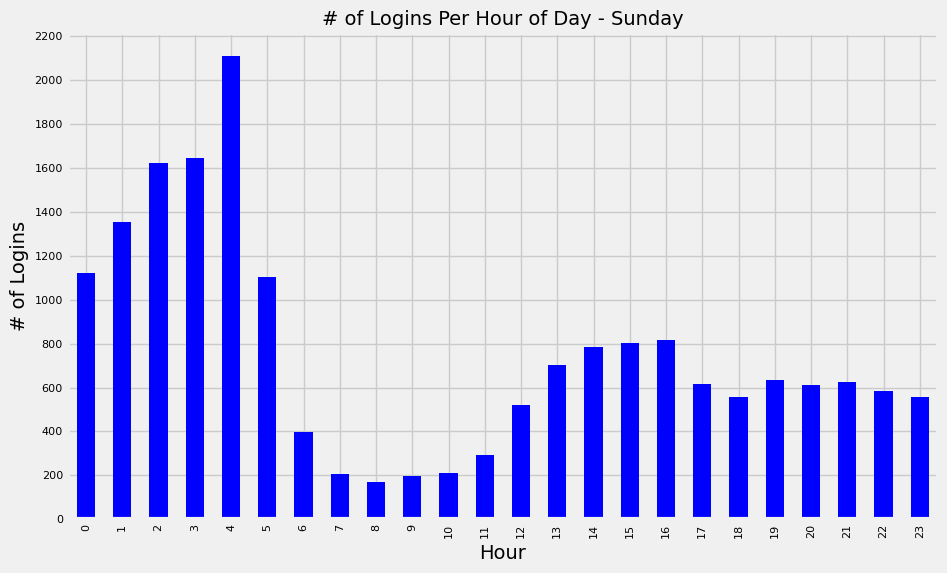

In [16]:
index_hour = logins_per_bucket.index.hour
hourly_logins = logins_per_bucket.groupby(index_hour)['# of Logins'].sum()
np.mean(hourly_logins)
for day in range(7):
    day = logins_per_bucket[logins_per_bucket.index.dayofweek==day]
    day_name_mapping = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    day_name = day.index.dayofweek.map(day_name_mapping)[0]
    index_hour = day.index.hour
    hourly_logins = day.groupby(index_hour)['# of Logins'].sum()
    ax = hourly_logins.plot(figsize=(10, 6), kind='bar', color='blue', fontsize=8)
    _ = ax.set_title(f'# of Logins Per Hour of Day - ' + day_name, fontsize=14)
    _ = ax.set_xlabel('Hour')
    _ = ax.set_ylabel('# of Logins')
    _ = ax.set_yticks(np.arange(0, 2251, 200))
    plt.show()

This confirms a lot of what we thought. During the week, logins peek at lunch, and the one exception is Friday (the start of the weekend). On Saturday and Sunday, logins peek in the early morning (and Saturday night) - times when people can stay up and not have to be up early for work.

### Modeling the data 

While there appears to be a seasonal component to our data, and both the mean and variance look like they're increasing over time (suggesting that the data is not stationary), let's plot the autocorrelation to see if that suggests the same.

### Autocorrelation (weeks marked in red)

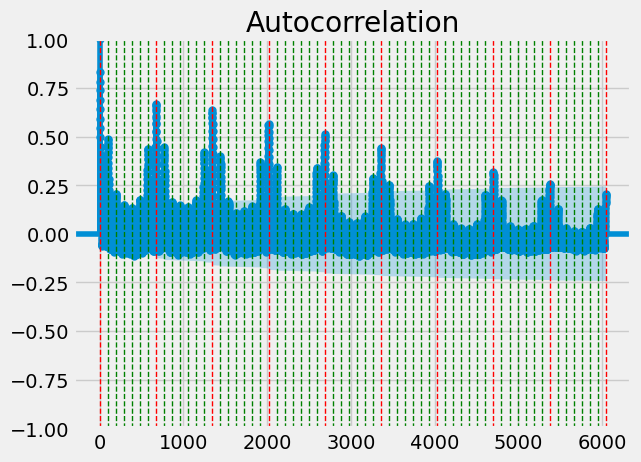

In [17]:
fig = tsaplots.plot_acf(logins_per_bucket['# of Logins'], lags=6048)
for x in range(0, 6049, 96):
    if x % 7 == 0:
        plt.axvline(x=x, ymin=0, ymax=1, color="red", linestyle="--", linewidth=1)
    else:
        plt.axvline(x=x, ymin=0, ymax=1, color="green", linestyle="--", linewidth=1)

The autocorrelation decays very slowly suggesting that our data is not stationary. There also appears to be a strong seasonal component by week. Let's decompose this into its constituant parts.

### Decompose into trend, seasonality, and residuals

C:\Users\7037m\AppData\Local\Temp\ipykernel_6304\1808299694.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  _ = plt.subplot(411)


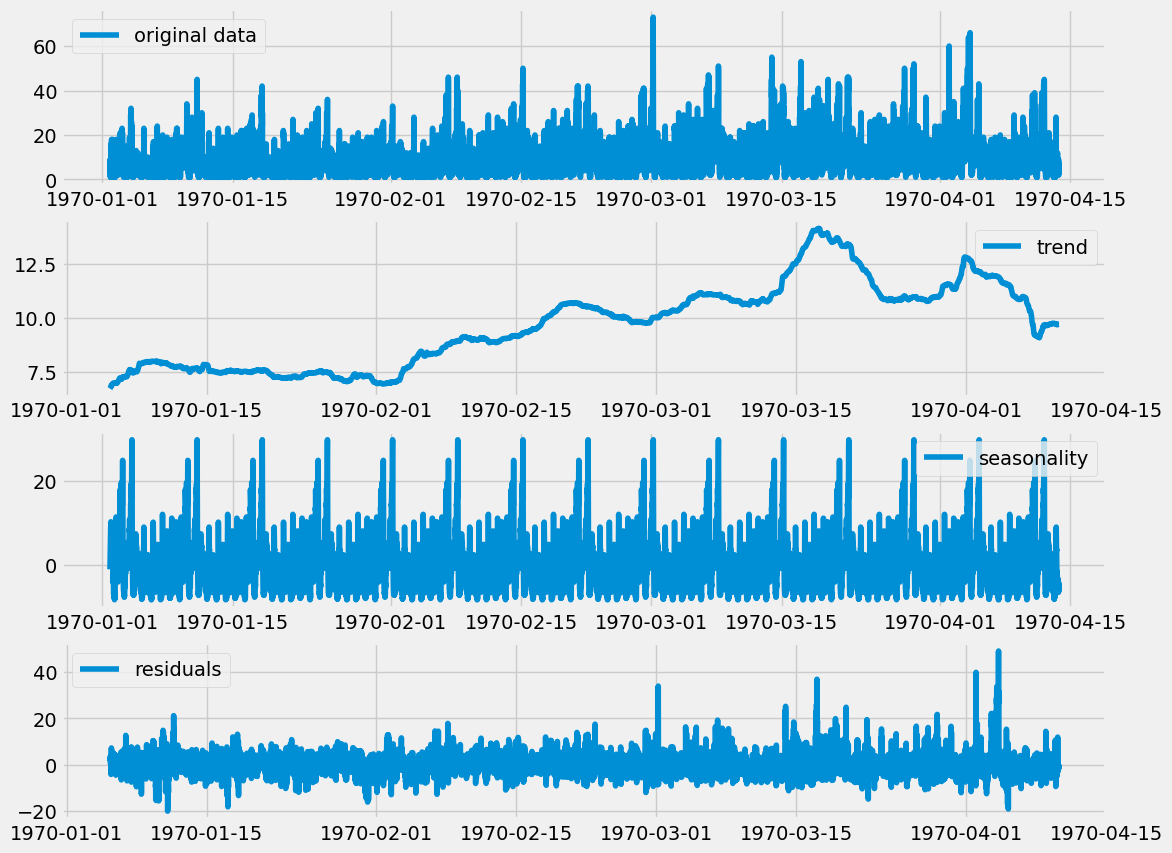

In [18]:
plt.subplots(figsize=(12, 10))
decomposition = sm.tsa.seasonal_decompose(logins_per_bucket['# of Logins'], period=672)
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid
_ = plt.subplot(411)
_ = plt.plot(logins_per_bucket['# of Logins'], label='original data')
_ = plt.legend()
_ = plt.subplot(412)
_ = plt.plot(trend, label='trend')
_ = plt.legend()
_ = plt.subplot(413)
_ = plt.plot(seasonal, label='seasonality')
_ = plt.legend()
_ = plt.subplot(414)
_ = plt.plot(residuals, label='residuals')
_ = plt.legend()

There indeed is a positive trend and a strong weekly, seasonal component. Let's make the data stationary and decide on what kind of model would be best for modeling this data.

### Test for Stationarity

In [19]:
kpss(logins_per_bucket['# of Logins'])

C:\Users\7037m\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.678665214905677,
 0.01,
 55,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Take log of logins

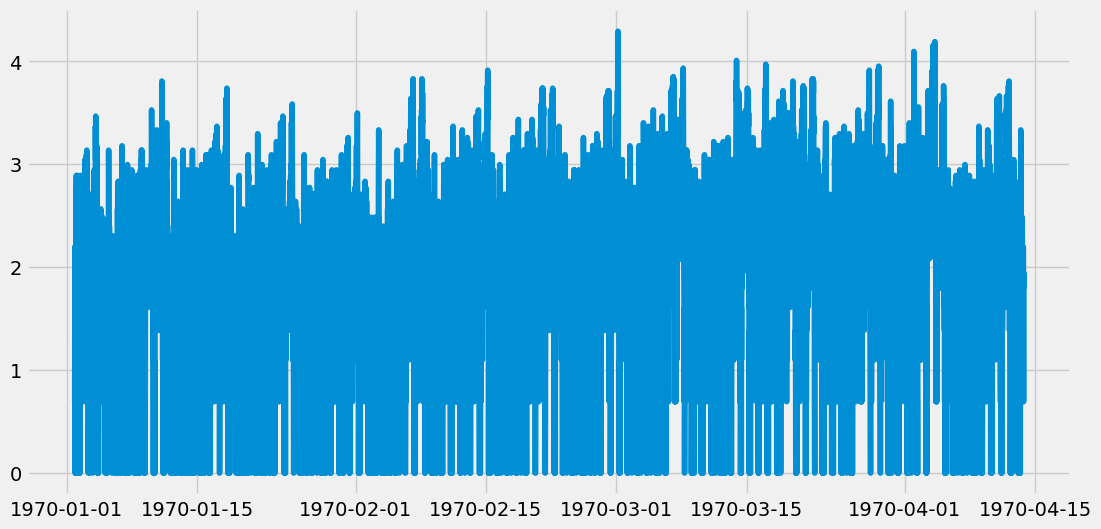

In [20]:
log_logins = np.log(logins_per_bucket['# of Logins'])
plt.subplots(figsize=(12, 6))
_ = plt.plot(log_logins)

### Take differentials of logged data

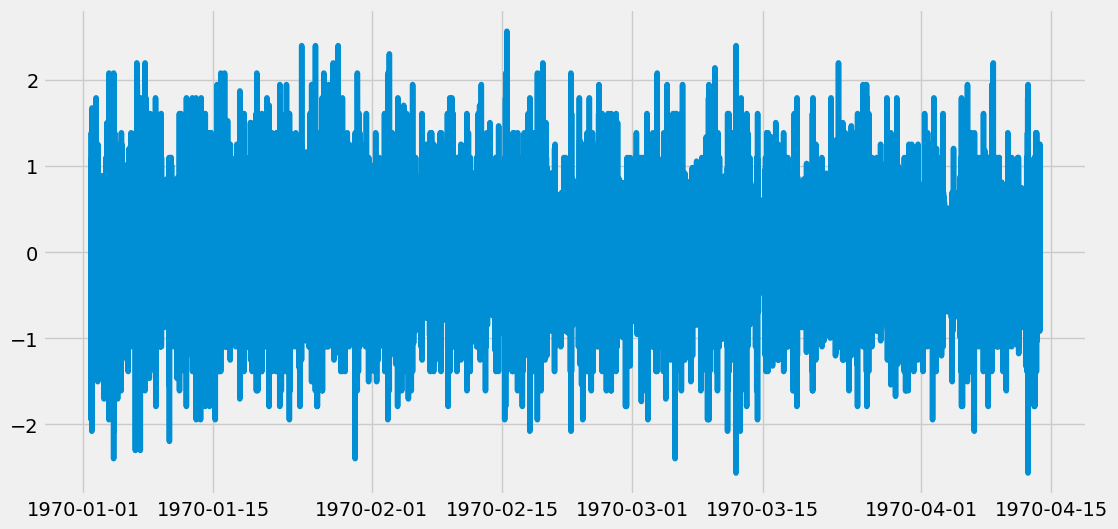

In [21]:
log_logins_differences = log_logins.diff().dropna()
plt.subplots(figsize=(12, 6))
_ = plt.plot(log_logins_differences)

### Test again for stationarity

In [22]:
kpss(log_logins_differences)

C:\Users\7037m\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.0019122281869930857,
 0.1,
 28,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The data is now stationary. Let's plot the acf and pacf to give us an idea of what kind of model would work best.

### Plot acf and pacf

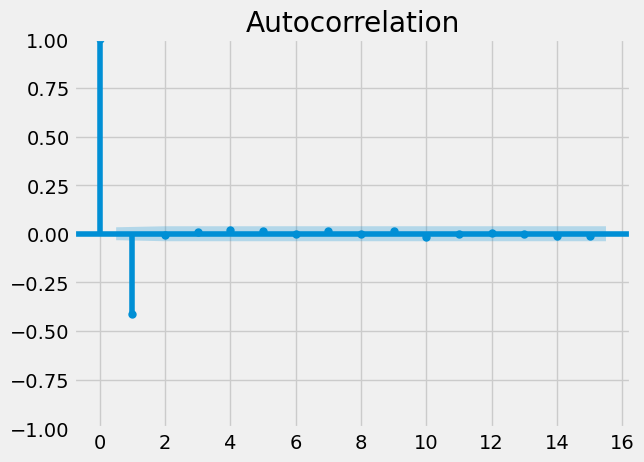

In [23]:
fig = tsaplots.plot_acf(log_logins_differences, lags=15, alpha=.001)

C:\Users\7037m\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


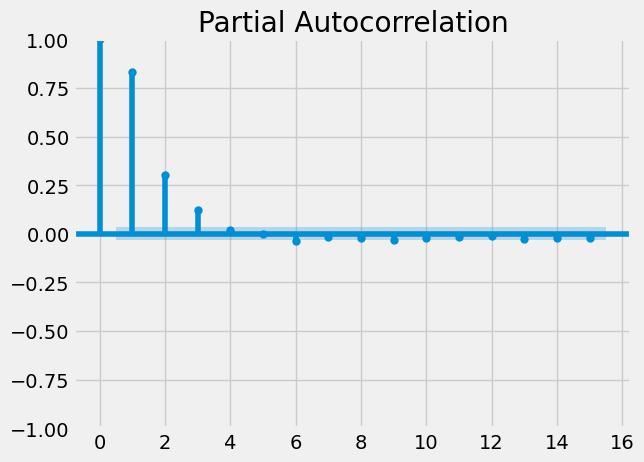

In [24]:
fig = tsaplots.plot_pacf(logins_per_bucket['# of Logins'], lags=15, alpha=.001)

The acf is significant at lag 1 and the pacf has geometric decay suggesting that an MA(1) model would be best for this data.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

There are two ways that I thought of to approach this. The first way is straightforward and the second gets at the likely larger problem that the managers of city operations are trying to address. The first way would be to measure the difference between the average toll paid per ride for each driver after the experiment was underway and the average toll paid per ride prior to the experiment. You would conduct a paired t-test with each driver's tolls paid per ride (before and after the intervention) as the variable of interest. This would directly test whether the drivers are using the toll bridge more and help answer that question. The second way would be to try to answer the question, "How can we optimize rider wait time in each city?" Ideally, the equilibrium would be when the wait times were identical in each city, so you would look at the absolute difference in average wait times and see if they decrease after the experiment. Again, a paired t-test could help you answer this question.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a) how you will implement the experiment
    b) what statistical test(s) you will conduct to verify the significance of the observation
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

In both cases, a one-way paired samples t-test would be conducted to verify the significance of the observation. Suppose the experiment took place over 60 days. In the former solution, you would collect data from each driver for the first 30 days on how much they paid in tolls and how many rides they completed. You would then implement the policy change, and collect 30 additional days of data. Then, you would conduct the test, and if the p-value was less than .01, you would reject the Null hypothesis that the policy had no effect. You would advise the city operations team that the policy worked, but they had to decide based on other statistics (such as the effect size) if the effect was practically significant / worth the cost. In the latter solution, you would collect data for the first 30 days on the average wait time in each city and then take the absolute difference between the two each day. You would then implement the policy change and do the same thing. Then, you'd conduct the test, look at the p-value, and decide whether or not to reject the Null hypothesis. Finally, the effect size would help you decide if the policy change was worth the cost.

# Part 3 ‐ Predictive modeling

### Read in JSON data

In [25]:
rides = pd.read_json('ultimate_data_challenge.json')

### View Data

In [26]:
rides.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

### Check dtypes and make sure they are correct

In [27]:
rides.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [28]:
rides['signup_date'] = pd.to_datetime(rides['signup_date'])
rides['last_trip_date'] = pd.to_datetime(rides['last_trip_date'])

### Binorize categorical data and create "Active" column

In [29]:
print(f'Phone\n {rides.phone.drop_duplicates()}\n')
print(f'Ultimate Black User\n {rides.ultimate_black_user.drop_duplicates()}\n')
print(f'City\n {rides.city.drop_duplicates()}')

Phone
 0       iPhone
1      Android
134       None
Name: phone, dtype: object

Ultimate Black User
 0     True
1    False
Name: ultimate_black_user, dtype: bool

City
 0    King's Landing
1           Astapor
4        Winterfell
Name: city, dtype: object


In [30]:
rides['iphone'] = [1 if x == 'iPhone' else 0 for x in rides['phone']]
rides['android'] = [1 if x == 'Android' else 0 for x in rides['phone']]
rides['ultimate_black_user'] = [1 if x == True else 0 for x in rides['ultimate_black_user']]
rides['astapor'] = [1 if x == 'Astapor' else 0 for x in rides['city']]
rides['winterfell'] = [1 if x == 'Winterfell' else 0 for x in rides['city']]
rides['six_month_mark'] = rides['signup_date'] + timedelta(days=180)
rides['days_since_last_ride'] = (rides['six_month_mark'] - rides['last_trip_date']).dt.days
rides['Active'] = [1 if x <= 30 else 0 for x in rides['days_since_last_ride']]

In [31]:
rides = rides.drop(['city', 'signup_date', 'six_month_mark', 'last_trip_date', 'phone', 'days_since_last_ride'], axis=1)

### View summary statistics

In [32]:
print(rides.Active.value_counts())
print('')
print(rides.Active.value_counts() / len(rides.Active))

Active
0    37286
1    12714
Name: count, dtype: int64

Active
0    0.74572
1    0.25428
Name: count, dtype: float64


In [33]:
rides.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct  ultimate_black_user   weekday_pct      avg_dist  \
count  50000.000000          50000.00000  50000.000000  50000.000000   
mean       8.849536              0.37708     60.926084      5.796827   
std       19.958811              0.48466     37.081503      5.707357   
min        0.000000              0.00000      0.000000      0.000000   
25%        0.000000              0.00000     33.300000      2.420000   
50%        0.000000              0.00000     66.700000      3.880000   
75%        8.600000              1.00000    100.000000      6.940000   
max      100.000000              1.00000    100.000000    160.960000   

       avg_rating_by_driver        iphone       android       astapor  \
count          49799.000000  50000.000000  50000.000000  50000.000000   
mean               4.778158      0.691640      0.300440      0.330680   
std                0.446652      0.461821      0.458454      0.470463   
min                1.000000      0.000000      0.000000      0.000000   
25%                4.700000      0.000000      0.000000      0.000000   
50%                5.000000      1.000000      0.000000      0.000000   
75%                5.000000      1.000000      1.000000      1.000000   
max                5.000000      1.000000      1.000000      1.000000   

         winterfell       Active  
count  50000.000000  50000.00000  
mean       0.466720      0.25428  
std        0.498896      0.43546  
min        0.000000      0.00000  
25%        0.000000      0.00000  
50%        0.000000      0.00000  
75%        1.000000      1.00000  
max        1.000000      1.00000

About a quarter of riders were retained after six months.

### Exploratory Data Analysis

In [34]:
def get_avg_by_num(dataset, var):
    print(var)
    means = dataset.groupby('Active')[var].mean()
    print(means)
    print(f'{(means[1] - means[0]) / dataset[var].std():.2f} std dev')
    print('')

print('Mean values by Active or Not Active:')
for var in rides.columns.drop('Active'):
    get_avg_by_num(rides, var)

Mean values by Active or Not Active:
trips_in_first_30_days
Active
0    1.813093
1    3.642205
Name: trips_in_first_30_days, dtype: float64
0.48 std dev

avg_rating_of_driver
Active
0    4.604828
1    4.593229
Name: avg_rating_of_driver, dtype: float64
-0.02 std dev

avg_surge
Active
0    1.073883
1    1.077345
Name: avg_surge, dtype: float64
0.02 std dev

surge_pct
Active
0    8.641788
1    9.458793
Name: surge_pct, dtype: float64
0.04 std dev

ultimate_black_user
Active
0    0.330902
1    0.512506
Name: ultimate_black_user, dtype: float64
0.37 std dev

weekday_pct
Active
0    60.756944
1    61.422117
Name: weekday_pct, dtype: float64
0.02 std dev

avg_dist
Active
0    6.103564
1    4.897266
Name: avg_dist, dtype: float64
-0.21 std dev

avg_rating_by_driver
Active
0    4.783755
1    4.761795
Name: avg_rating_by_driver, dtype: float64
-0.05 std dev

iphone
Active
0    0.643056
1    0.834120
Name: iphone, dtype: float64
0.41 std dev

android
Active
0    0.348603
1    0.159195
Name: andr

Looking at the means between groups, it looks like there are a few variables that are different between groups (e.g. trips_in_first_30_days).

Active vs. Not Active


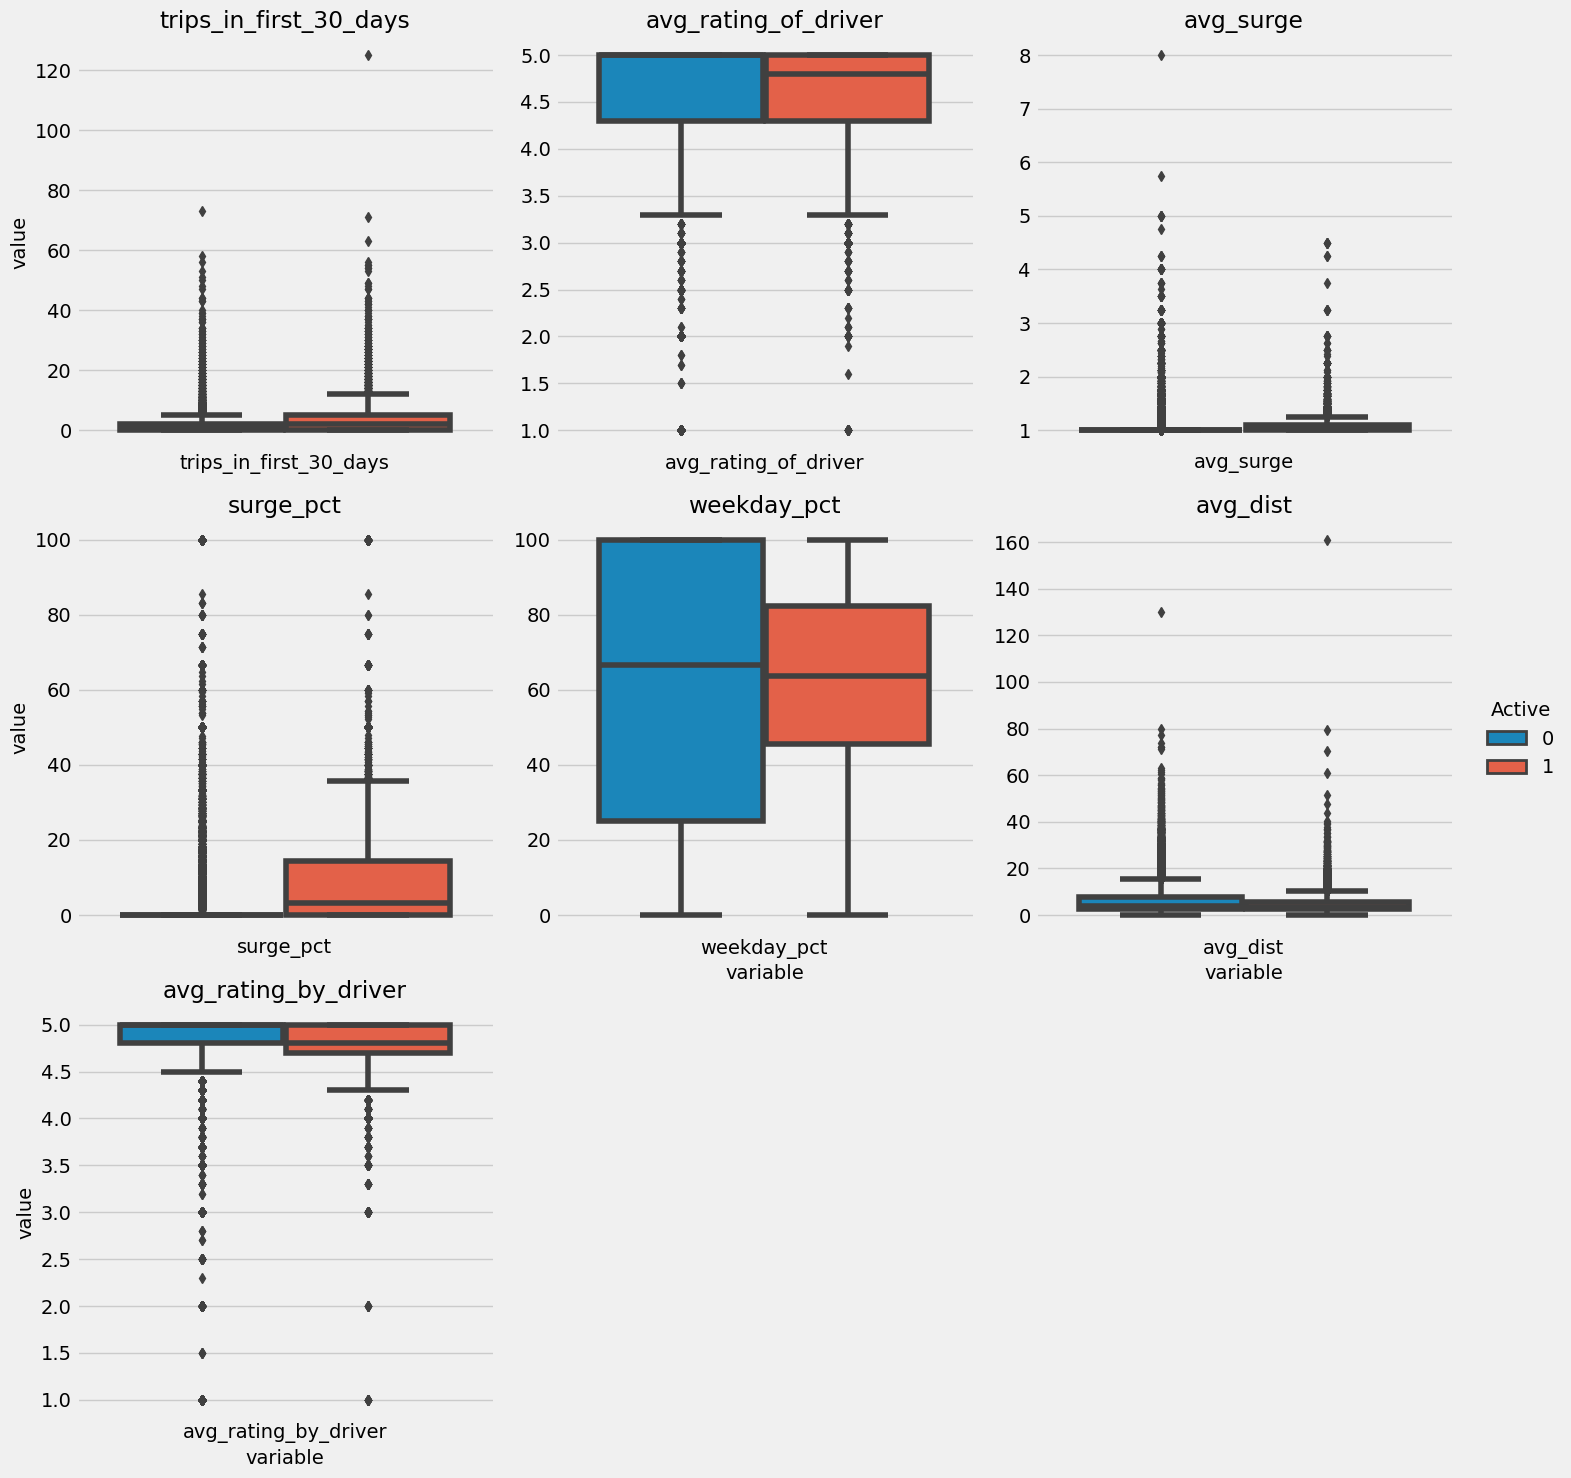

In [35]:
def get_boxplots(dataset, col_names, num_boxplot_cols):
    df = dataset.melt(id_vars='Active', value_vars=col_names)
    g = sns.catplot(
        data=df, 
        y='value', 
        x='variable', 
        hue='Active', 
        kind='box', 
        col_wrap=num_boxplot_cols, 
        col='variable', 
        sharex=False,
        sharey=False)
    g.set_titles('{col_name}')
    g.tight_layout()
    
cols = rides.columns.drop(['ultimate_black_user', 'iphone', 'android', 'astapor', 'winterfell'])
print('Active vs. Not Active')
get_boxplots(rides, cols, 3)

Looking at the boxplots, it looks like some of the variables are highly skewed. We'll want to try normalizing the data in our model to see if that helps.

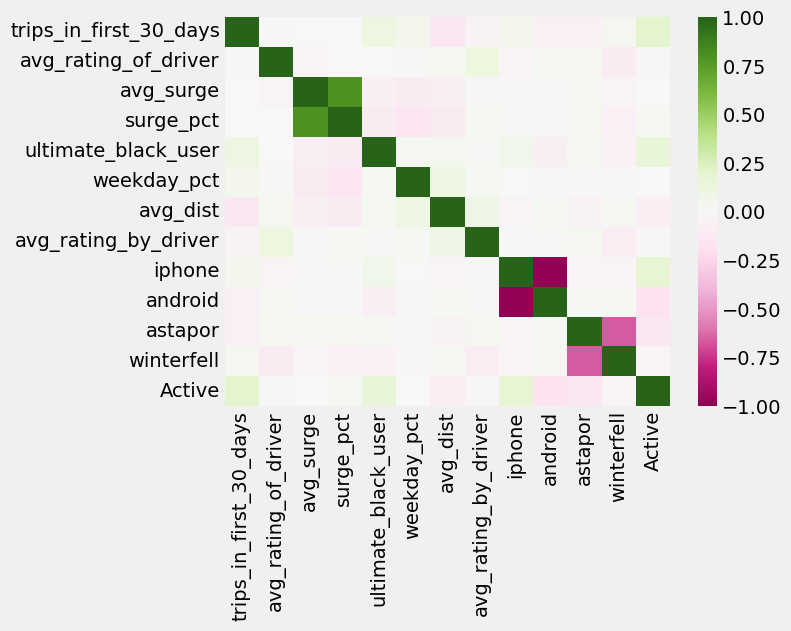

In [36]:
sns.heatmap(rides.corr(), vmin=-1, vmax=1,cmap='PiYG');

In [37]:
def get_correlation_coefficient(dataset, var):
    df = dataset[[var, 'Active']]
    df = df.dropna()
    correlation_coeff = df[var].corr(df['Active'])
    print(f'Correlation coefficient - {var} and Active: {correlation_coeff}')
    
print('Correlation coefficients')
for var in rides.columns.drop('Active'):
    get_correlation_coefficient(rides, var)

Correlation coefficients
Correlation coefficient - trips_in_first_30_days and Active: 0.21001097188491064
Correlation coefficient - avg_rating_of_driver and Active: -0.00845208768681022
Correlation coefficient - avg_surge and Active: 0.006780464214670543
Correlation coefficient - surge_pct and Active: 0.017825377593380782
Correlation coefficient - ultimate_black_user and Active: 0.16316877255355466
Correlation coefficient - weekday_pct and Active: 0.0078113499148401554
Correlation coefficient - avg_dist and Active: -0.09203816580215494
Correlation coefficient - avg_rating_by_driver and Active: -0.02142619208547693
Correlation coefficient - iphone and Active: 0.1801576217245152
Correlation coefficient - android and Active: -0.17990829697808
Correlation coefficient - astapor and Active: -0.13465206332600851
Correlation coefficient - winterfell and Active: -0.023832819494495443


The heatmap shows that avg_surge and surge_pct are highly correlated. Iphone and android are, as well. I am going to remove those variables to prevent multicollinearity.

In [38]:
rides = rides.drop(['avg_surge', 'android'], axis=1)

### Model Training

### Split the data into training and testing sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(rides.drop(columns=['Active']), rides.Active, test_size=0.3, 
                                                    random_state=47)

### Baseline Model

In [40]:
dummy = DummyClassifier(strategy='constant', constant=1)

In [41]:
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
f1_score(y_test, y_pred)

0.40603581106211145

The baseline model (predicting that every customer is retained) has an f1-score of .40. We'll want to improve on that in our other models. I have chosen to test a Logistic Regression model, Adaboost with Decision Tree classifier model, and Random Forest model for this problem. These are models that I've found to be good for classification tasks in the past and offer the ability to evaluate feature importances.

### Logistic Regression

In [42]:
pipe_log_reg = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

In [43]:
grid_params = {
        'simpleimputer__strategy': ['mean', 'median'],
        'standardscaler': [StandardScaler(), MinMaxScaler(), None],
        'simpleimputer__strategy': ['mean', 'median'],
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
        'logisticregression__fit_intercept': [True, False],
        'logisticregression__l1_ratio': [0, .1, .25, .5, .75, 1],
        'logisticregression__penalty': ['elasticnet', None],
        'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [44]:
warnings.filterwarnings("ignore")
log_reg_randomized_cv = RandomizedSearchCV(pipe_log_reg, param_distributions=grid_params, cv=5, n_jobs=-1, 
                                           n_iter = 60, scoring='f1')
log_reg_randomized_cv.fit(X_train, y_train)
print(log_reg_randomized_cv.best_params_)
print(f'Best Score = {log_reg_randomized_cv.best_score_}')

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'median', 'logisticregression__solver': 'newton-cholesky', 'logisticregression__penalty': None, 'logisticregression__l1_ratio': 0.1, 'logisticregression__fit_intercept': False, 'logisticregression__C': 10}
Best Score = 0.510614554259399


### Adaboost - Decision Tree Classifier

In [45]:
decision_tree = DecisionTreeClassifier()

pipe_adaboost_decision_tree = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [46]:
grid_params = {
    'adaboostclassifier__estimator': [decision_tree],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [100, 200, 300, 400, 500],
    'adaboostclassifier__estimator__ccp_alpha': [.001, .01, .1, .25],
    'adaboostclassifier__estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'adaboostclassifier__estimator__max_depth': [1, 2, 3, 4],
    'adaboostclassifier__estimator__max_features': [None, 'auto', 'sqrt', 'log2'], 
    'adaboostclassifier__estimator__min_impurity_decrease': [.0001, .001, .01, .1],
    'adaboostclassifier__estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    'adaboostclassifier__estimator__min_samples_split': [2, 3, 4, 5],
    'adaboostclassifier__estimator__splitter': ['best', 'random']
}

In [47]:
adaboost_decision_tree_randomized_cv = RandomizedSearchCV(pipe_adaboost_decision_tree, param_distributions=grid_params,
                                                    cv=5, n_jobs=-1, n_iter = 60, scoring='f1')
adaboost_decision_tree_randomized_cv.fit(X_train, y_train)
print(adaboost_decision_tree_randomized_cv.best_params_)
print(f'Best Score = {adaboost_decision_tree_randomized_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'median', 'adaboostclassifier__n_estimators': 400, 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__estimator__splitter': 'best', 'adaboostclassifier__estimator__min_samples_split': 5, 'adaboostclassifier__estimator__min_samples_leaf': 5, 'adaboostclassifier__estimator__min_impurity_decrease': 0.001, 'adaboostclassifier__estimator__max_features': None, 'adaboostclassifier__estimator__max_depth': 4, 'adaboostclassifier__estimator__criterion': 'entropy', 'adaboostclassifier__estimator__ccp_alpha': 0.001, 'adaboostclassifier__estimator': DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4,
                       min_impurity_decrease=0.001, min_samples_leaf=5,
                       min_samples_split=5), 'adaboostclassifier__algorithm': 'SAMME.R'}
Best Score = 0.5176643259027169


### Random Forest

In [48]:
pipe_random_forest_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    RandomForestClassifier()
)

In [49]:
grid_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__ccp_alpha': [.0001, .001, .01, .1],
    'randomforestclassifier__criterion': ["gini", "entropy", "log_loss"],
    'randomforestclassifier__max_depth': [3, 5, 10, 20, None],
    'randomforestclassifier__max_features': ["sqrt", "log2", None],
    'randomforestclassifier__max_leaf_nodes': [10, 20, 50, 100, 200, None],
    'randomforestclassifier__min_impurity_decrease': [0, .0001, .001, .01, .1],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
    'randomforestclassifier__n_jobs': [-1]
}

In [50]:
random_forest_randomized_cv = RandomizedSearchCV(pipe_random_forest_all, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 60, scoring='f1')
random_forest_randomized_cv.fit(X_train, y_train)
print(random_forest_randomized_cv.best_params_)
print(f'Best Score = {random_forest_randomized_cv.best_score_}')

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'median', 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_impurity_decrease': 0, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__ccp_alpha': 0.0001, 'randomforestclassifier__bootstrap': True}
Best Score = 0.5081278022426468


### Final Model Selection

In [51]:
def f1_score_output(model, X_train, X_test, y_train, y_test):
    f1 = cross_validate(model.best_estimator_, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    f1_mean = np.mean(f1['test_score'])
    f1_std = np.std(f1['test_score'])
    print('Cross-Validation (Training Data)')
    print(f1_mean, f1_std)
    print('Test Score')
    print(f1_score(y_test, model.best_estimator_.predict(X_test)))

#### Logistic Regression

In [52]:
f1_score_output(log_reg_randomized_cv, X_train, X_test, y_train, y_test)

Cross-Validation (Training Data)
0.510614554259399 0.002306511781817346
Test Score
0.5183499288762446


#### Adaboost - Decision Tree Estimator

In [53]:
f1_score_output(adaboost_decision_tree_randomized_cv, X_train, X_test, y_train, y_test)

Cross-Validation (Training Data)
0.5176643259027169 0.011822826593910799
Test Score
0.5231406180689043


#### Random Forest

In [54]:
f1_score_output(random_forest_randomized_cv, X_train, X_test, y_train, y_test)

Cross-Validation (Training Data)
0.5082657218030343 0.007002975696248923
Test Score
0.5097484276729559


After evaluating the models, the best performing model is the Adaboost model with Decision Tree estimator.

### Classification Report

In [55]:
y_predict = adaboost_decision_tree_randomized_cv.best_estimator_.predict(X_test)
classification_report_dict = classification_report(y_test, y_predict, output_dict=True)
classification_report_df = pd.DataFrame(dict(itertools.islice(classification_report_dict.items(), 2))).T
classification_report_df = classification_report_df[['precision', 'recall', 'f1-score']]
long_df = classification_report_df.reset_index().melt(id_vars='index')
long_df.columns = ['Active', 'Metric', 'Value']
long_df['Active'] = np.where(long_df['Active']=='1', 'active', 'not active')

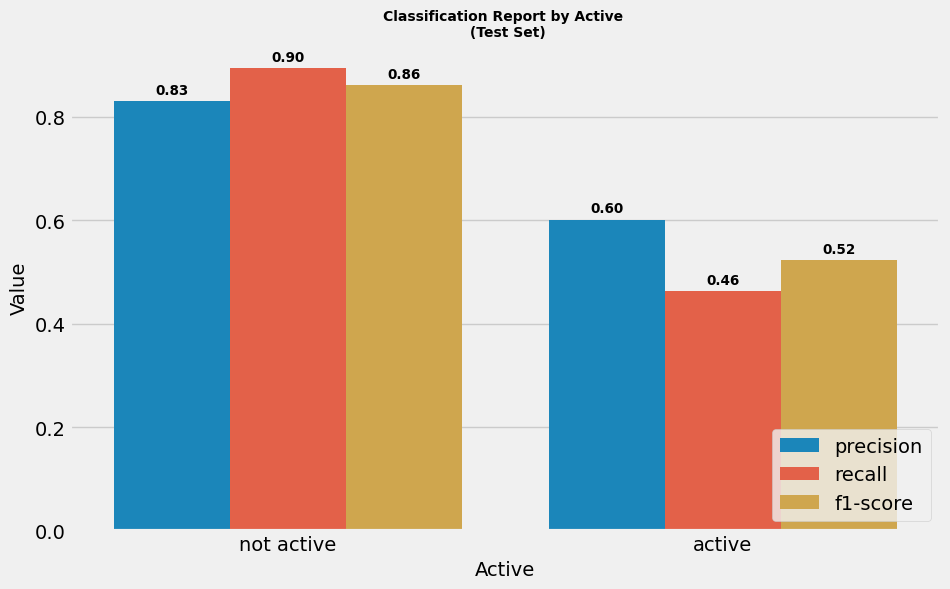

In [56]:
plt.figure(figsize=(10, 6))

bar_plot = sns.barplot(x='Active', y='Value', hue='Metric', data=long_df)

for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                       fontsize='x-small', xytext=(0, 8),
                       textcoords='offset points', fontweight='bold')

plt.title('Classification Report by Active \n (Test Set)', fontsize=10, fontweight='bold')
plt.xlabel('Active')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.show()

### ROC Curve

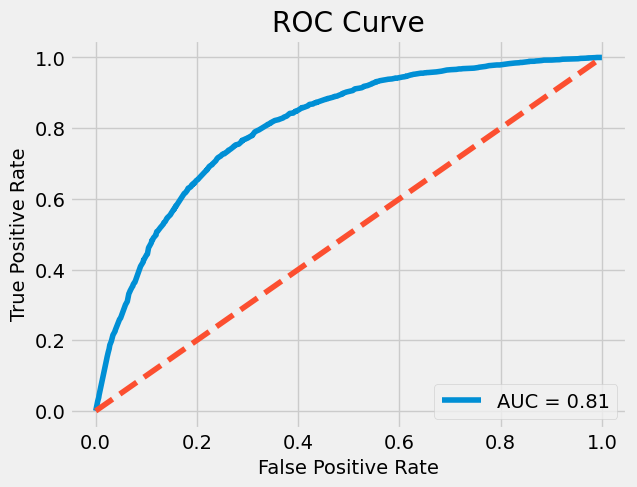

In [57]:
y_pred_proba = adaboost_decision_tree_randomized_cv.best_estimator_.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Confusion Matrices

In [58]:
def get_confusion_matrix(normalize):
    cm = confusion_matrix(y_test, y_predict, labels = adaboost_decision_tree_randomized_cv.best_estimator_.classes_)
    display_cm = ConfusionMatrixDisplay.from_estimator(adaboost_decision_tree_randomized_cv, X_test, y_test, 
                                                       display_labels = ['Not Active', 'Active'], normalize=normalize)

#### Counts

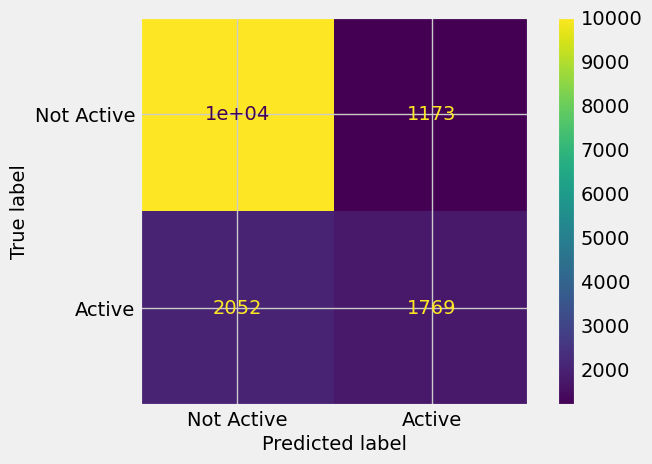

In [59]:
get_confusion_matrix(normalize=None)

#### Ratios

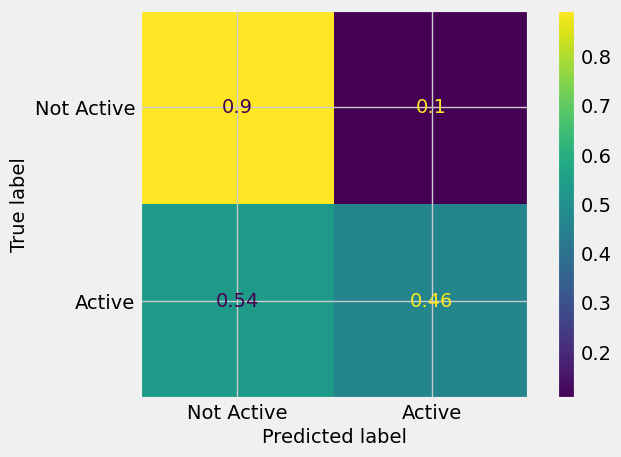

In [60]:
get_confusion_matrix(normalize='true')

The classification report shows that the model is better at predicting the majority class (not active). That being said the f1-score is higher than the baseline model, so it is performing better than guessing.

### Feature Importances

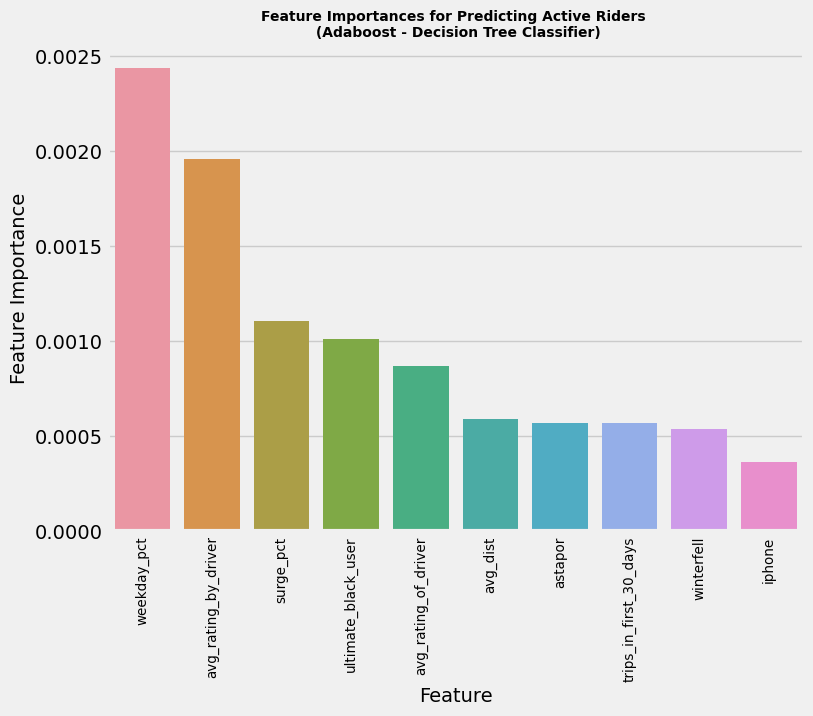

In [61]:
features = adaboost_decision_tree_randomized_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = adaboost_decision_tree_randomized_cv.best_estimator_.named_steps.adaboostclassifier.feature_importances_
feature_importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)

feature_importances = feature_importances.reset_index()
feature_importances.columns = ['Feature', 'Feature Importance']

plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Feature', y='Feature Importance', data=feature_importances)

_ = plt.title('Feature Importances for Predicting Active Riders \n (Adaboost - Decision Tree Classifier)', 
              fontsize=10, fontweight='bold')
_ = plt.xlabel('Feature')
_ = plt.xticks(rotation=90, fontsize='x-small')
_ = plt.ylabel('Feature Importance')

Looking at the feature importances, weekday_pct, avg_rating_by_driver, and avg_dist are the most important features.

### Takeaways

Ultimate can use this model and the feature importances to help identify customers who are likely to churn and try to improve upon the things that riders find most important. In the future, they'll likely want to test other models, as well, that control for the class imbalance, which can further improve their ability to model this.